# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
sns.set_style('darkgrid')

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "data/"

In [5]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

<AxesSubplot:xlabel='Survived', ylabel='count'>

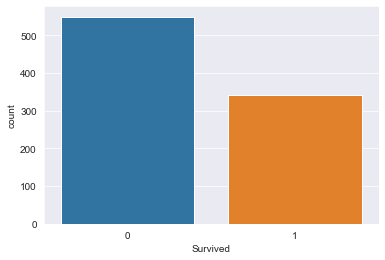

In [7]:
sns.countplot(x='Survived', data=data)

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [8]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

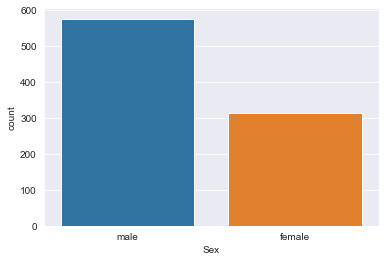

In [9]:
sns.countplot(x='Sex', data=data)

In [10]:
data.groupby('Sex')['Survived'].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

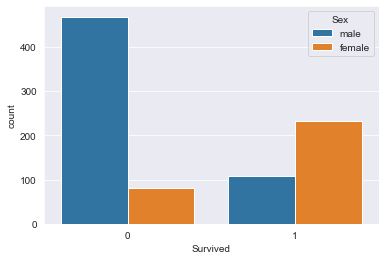

In [11]:
sns.countplot(x='Survived', hue='Sex', data=data)

There were more men than women. I think we have relationship between gender and survival. Men tried to survive women and allowed them to sit into boats. One more reason - workers (or sailors) on Titanic were men. As we know a lot of workers were died. So, women survived more than men.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

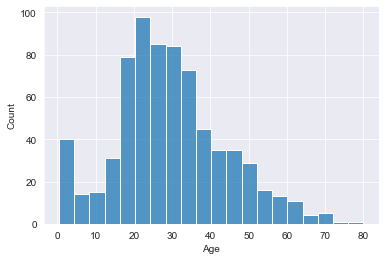

In [12]:
sns.histplot(data['Age'])

I can see from this histogram that many children is below 5 years old. Some of them are babies which we see that there's a peak around 1 year. This histogram will have an almost normal distribution if there isn't a peak around 1 year old.

In [13]:
data.query('Survived == 0')['Age'].median()

28.0

In [14]:
data.query('Survived == 0')['Age'].mean()

30.62617924528302

In [15]:
data.query('Survived == 1')['Age'].median()

28.0

In [16]:
data.query('Survived == 1')['Age'].mean()

28.343689655172415

It shows that median is 28 year old, and mean is 29 year old. We can also tell that the distribution is normal when you have similar median and mean.

<AxesSubplot:xlabel='Age', ylabel='Count'>

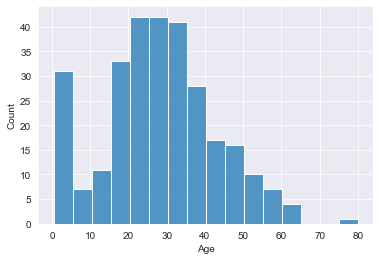

In [17]:
sns.histplot(data.query('Survived == 1')['Age'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

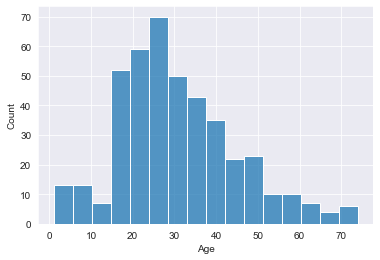

In [18]:
sns.histplot(data.query('Survived == 0')['Age'])

Overall plots tell us that the passengers' age is distributed around mid-end 20's. 

<AxesSubplot:xlabel='Survived', ylabel='Age'>

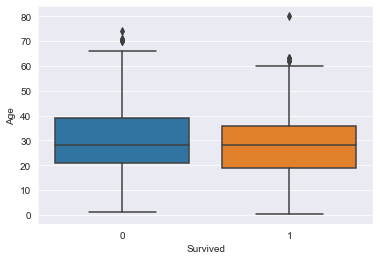

In [19]:
sns.boxplot(data=data, x='Survived', y='Age')

From the plot above, there seems to be no clear correlation between survival and the age of a person on the Titanic.  
Let's have a look on another one plot.

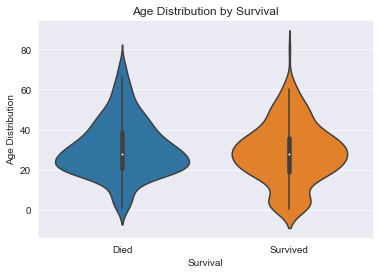

In [20]:
p = sns.violinplot(data = data, x = 'Survived', y = 'Age')
p.set(title = 'Age Distribution by Survival', 
        xlabel = 'Survival', 
        ylabel = 'Age Distribution', 
        xticklabels = ['Died', 'Survived']);

So from the above plot we can understand that, some of the older people died (between 50-70) and some of the younger people (between 20-40) survived more.  
The distribution of the age shows bimodal distribution of people who survived. Many old people died, though we see 1 80 year-old man survived. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

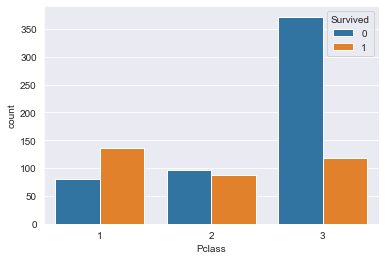

In [21]:
sns.countplot(x='Pclass',hue='Survived',data=data)

We can now visualize the variable ‘Embarked’ with ‘Survived.’

<AxesSubplot:xlabel='Survived', ylabel='count'>

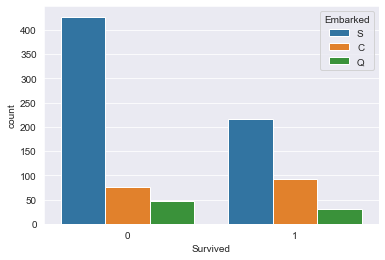

In [22]:
sns.countplot(x='Survived',hue='Embarked',data=data)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

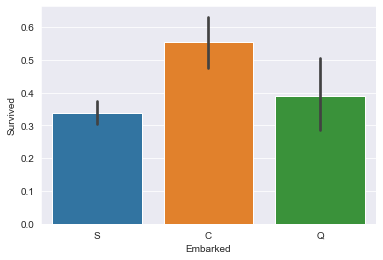

In [23]:
sns.barplot(x='Embarked',y='Survived',data=data)

From the plots above, we can see that passengers in the third class were far less likely to survive than passengers in the first and second class.  
And we can see that people from Port of Embarkation = "C" (Cherbourg) were far more likely to survive.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [24]:
round((data.isnull().sum()*100)/len(data),2)

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         19.87
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.00
Cabin       77.10
Embarked     0.22
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

- Cabin attribute has too much missing values, so I'll drop it in the first attempt.  
- Embarked attribute I can analyze due to values balance. And maybe put the value of attribute with the lowest total value. Or maybe analyze the target values due to rows with missing values and put the value according to probability of survation for the Embarked values. E.g., if Embarked value "C" has the most probability of survation and rows with missing values equals to Survived = 1, so put value "C" for all missing values.  
- I don't know how to fill Age missing values. Initially, I think I'll put median value due to no clear correlation between survival and the age of a person on the Titanic and that median value for survived and not survived is the same. So, if we put median value we won't increase significance of some class.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [25]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))

In [26]:
y_train = train_data['Survived']

Let's drop both target and Cabin attribute from the dataset

In [27]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


For the first attempt let's drop Survived (it's the target), PassengerId (no useful information for us), Cabin (a lot of missing values), PassengerID, Name and Ticket columns.  
Both Sex and Embarked columns let's convert to numeric.

In [28]:
X_train = train_data.drop(['Survived', 'PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)

In [29]:
X_train['Sex'] = X_train['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [30]:
X_train['Embarked'] = X_train['Embarked'].fillna('C')

In [31]:
X_train['Embarked'] = X_train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [32]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())

In [33]:
X_train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [34]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [37]:
lr = LogisticRegression(max_iter=1000,random_state=42)
knn = KNeighborsClassifier()
scaler = StandardScaler()

In [38]:
models_accuracy = []

# Without feature scaling, logistic regression
models_accuracy.append(cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=5).mean())

# Without feature scaling, knn
models_accuracy.append(cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5).mean())

#With scaling StandardScaler + LogisticRegression
model_scaling = make_pipeline(StandardScaler(), lr)
models_accuracy.append(cross_val_score(model_scaling, X_train, y_train, scoring='accuracy', cv=5).mean())

#With scaling StandardScaler + Knn
model_scaling_knn = make_pipeline(StandardScaler(), knn)
models_accuracy.append(cross_val_score(model_scaling_knn, X_train, y_train, scoring='accuracy', cv=5).mean())

In [39]:
accuracy_df = pd.DataFrame({'Accuracy': models_accuracy}, index = ['LogisticRegression', 'KNN', 
                                                             'StandardScaler + LogisticRegression',
                                                             'StandardScaler + KNN'
                                                            ])
accuracy_df

,Accuracy
LogisticRegression,0.793491
KNN,0.683554
StandardScaler + LogisticRegression,0.791243
StandardScaler + KNN,0.813709


So StandardScaler+KNN gives us the better accuracy. Let's try to make prediction and submit it

In [40]:
def make_submission(df, pred, n):
    '''
    Create submission file
    :param df: test dataframe
    :param pred: predictions
    :n: numner of the file
    :returns: submission file in the appropriate format
    '''
    submission = pd.DataFrame({
            "PassengerId": df["PassengerId"],
            "Survived": pred
        })

    submission.to_csv('submission_titanic_{}.csv'.format(n), index=False)

Read test data from the file

In [41]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [42]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Transform test data in the same way as train data

In [43]:
X_test = test_data.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)
X_test['Sex'] = X_test['Sex'].map({'female': 1, 'male': 0}).astype(int)
X_test['Embarked'] = X_test['Embarked'].fillna('C')
X_test['Embarked'] = X_test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(0)

In [44]:
X_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Make prediction and create sunmission file

In [45]:
model_scaling_knn.fit(X_train, y_train)
y_pred_knn = model_scaling_knn.predict(X_test)
make_submission(test_data, y_pred_knn, '03')

**Summary:**  
On Kaggle the result is not great. It's about 0.74. KNN was overfitted on the train data.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Initially, let's look on correlation matrix

<AxesSubplot:>

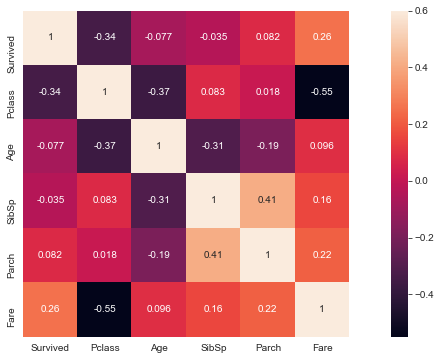

In [46]:
plt.figure(figsize=(15,6))
sns.heatmap(data.corr(), vmax=0.6, square=True, annot=True)

Some features are categorical, so we can't see them into correlation matrix.  
Let's upload datasets one more time and start our work from scratch

In [47]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

There were a lot of different researches and attempts. I leave the last one with the highest score on Kaggle LB.  
All feature transformations I'm going to do on the both datasets.  
Initially, let's transform 'Sex' feature from categorical to numeric cause we saw that women survived more than men previously on plots. So, this feature could be important for the model.

In [48]:
train_test_data = [train_data, test_data]

In [49]:
for data in train_test_data:
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0}).astype(int)

As we can see in correlation matrix, 'Pclass' feature has a negative strong correlation with target, but as we saw on plots, this feature will influence on target.   
So, let's put it as is.

Then let's work with 'Age' feature.  
We saw on plots that there is a correlation between person's age and survival, not great but it could help.  
Let's fill empty values with median and split persons due to some ages:

In [50]:
for data in train_test_data:    
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data.loc[data['Age'] <= 11, 'Age'] = 0
    data.loc[(data['Age'] > 11) & (data['Age'] <= 18), 'Age'] = 1
    data.loc[(data['Age'] > 18) & (data['Age'] <= 22), 'Age'] = 2
    data.loc[(data['Age'] > 22) & (data['Age'] <= 27), 'Age'] = 3
    data.loc[(data['Age'] > 27) & (data['Age'] <= 33), 'Age'] = 4
    data.loc[(data['Age'] > 33) & (data['Age'] <= 40), 'Age'] = 5
    data.loc[(data['Age'] > 40) & (data['Age'] <= 66), 'Age'] = 6
    data.loc[ data['Age'] > 66, 'Age'] = 7

The next one is 'Embarked'. Let's fill the empty value with 'S' and convert the feature to numeric format.

In [51]:
for data in train_test_data:
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

We can see on correlation matrix that 'Fare' has a positive correlation with target. So let's use it in our calculations.  
Let's fill empty values with 'mean' value

In [52]:
for data in train_test_data:
    data['Fare'] = data['Fare'].fillna(train_data['Fare'].mean())

Both 'Sibsp' and 'Parch' features a low correlation with target feature. Let's try to combine them into something more powerfull by creating a new feature and analyze it.

In [53]:
for data in train_test_data:
    data['Family'] = data['SibSp'] + data['Parch']

In [54]:
pd.crosstab(train_data['Family'], train_data['Survived'])

Survived,0,1
Family,,
0,374,163
1,72,89
2,43,59
3,8,21
4,12,3
5,19,3
6,8,4
7,6,0
10,7,0


<AxesSubplot:xlabel='Family', ylabel='Survived'>

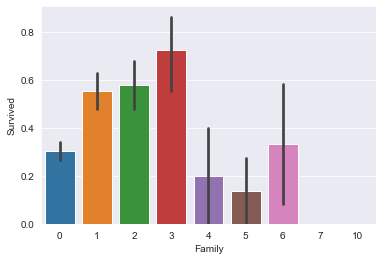

In [55]:
sns.barplot(x='Family',y='Survived',data=train_data)

As we can see, single persons and large families were far less likely to survive than passengers with not large family. let's transform this feature to another one - 'Alone'. 

In [56]:
for data in train_test_data:
    data['Alone'] = 0
    data.loc[data['Family'] == 1, 'Alone'] = 1

Now let's look on 'Name' feature. All names have a title. Let's get it from names and create a separate feature. We a re going to merge persons by 'Title', so we can say who was more likely to survive.

In [57]:
train_test_data = [train_data, test_data]
for dataset in train_test_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')

In [58]:
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


Let's merge some titles

In [59]:
for data in train_test_data: 
        data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
        data['Title'] = data['Title'].replace('Mlle', 'Miss')
        data['Title'] = data['Title'].replace('Ms', 'Miss')
        data['Title'] = data['Title'].replace('Mme', 'Mrs')   

In [60]:
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,0,1
Title,,
Master,40,0
Miss,0,185
Mr,517,0
Mrs,0,126
Other,20,3


In [61]:
pd.crosstab(train_data['Title'], train_data['Survived'])

Survived,0,1
Title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Other,15,8


So, let's convert 'Title' feature to numeric format.

In [62]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for data in train_test_data:
    data['Title'] = data['Title'].map(title_mapping)

I read that persons with long names survived more than with short. I think it's connected with the social status - rich people have longer names.  
Let's create a separate feature for the length of name.

In [63]:
for data in train_test_data:
    data['NameLength'] = data["Name"].apply(lambda x: len(x))

In [64]:
pd.crosstab(train_data['NameLength'], train_data['Survived'])

Survived,0,1
NameLength,,
12,1,1
13,1,1
14,2,1
15,13,2
16,20,6
17,33,9
18,40,10
19,49,15
20,28,11


let's merge values of this feature to bins.

In [65]:
for data in train_test_data:
    data.loc[data["NameLength"] <= 20, "NameLength"] = 0
    data.loc[(data["NameLength"] > 20)  &  (data["NameLength"] <= 40) , "NameLength"] = 1
    data.loc[(data["NameLength"] > 40)  &  (data["NameLength"] <= 55) , "NameLength"] = 2
    data.loc[data["NameLength"] > 55, "NameLength"] = 3

Initially we deleted 'Cabin' feature. Now we can try to interpret it. Cabin includes Deck number. Let's get it.

In [66]:
for data in train_test_data:
    data["Deck"]=data.Cabin.str[0]

In [67]:
train_data['Deck'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [68]:
test_data['Deck'].unique()

array([nan, 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

Let's fill empty values with some char, e.g. 'Z'. And as we can see test_data doesn't include 'T' value. 

In [69]:
for data in train_test_data:
    data['Deck'] = data['Deck'].fillna('Z')

In [70]:
pd.crosstab(train_data['Deck'], train_data['Survived'])

Survived,0,1
Deck,,
A,8,7
B,12,35
C,24,35
D,8,25
E,8,24
F,5,8
G,2,2
T,1,0
Z,481,206


Persons on decks 'A', 'B', 'C', 'D', 'E' were more likely to survive. Let's convert this feature to the numeris format according to this knowledge.  
Honestly, we don't know about test data. And we can's say for 100% that it's the same for test_data.  
But I think that it's true for 'A', 'B', 'C', 'D' decks.  

In [71]:
deck = {'Z':0, 'T':0, 'G':0, 'F':0, 'E':0, 'D':1, 'C':1, 'B':1, 'A':1}
for data in train_test_data:
    data['Deck'] = data['Deck'].map(deck).astype(int)

Let's look on correlation matrix

<AxesSubplot:>

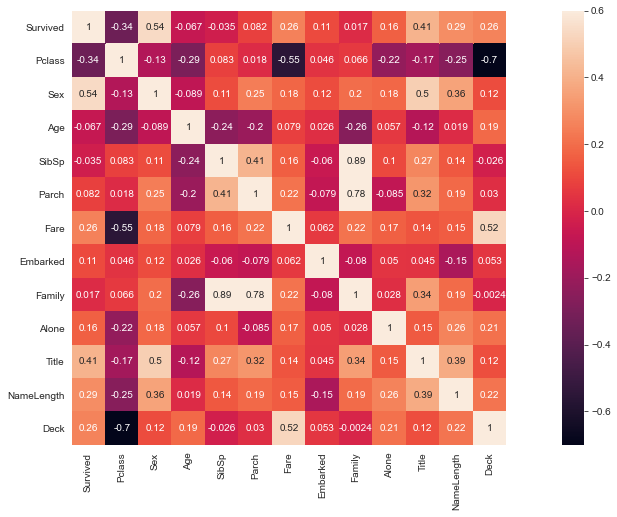

In [72]:
plt.figure(figsize=(20,8))
sns.heatmap(train_data.drop(['PassengerId'], axis=1).corr(), vmax=0.6, square=True, annot=True)

I think it's not bad. Let's try to learn it, but after deleting some features

In [73]:
X_train = train_data.drop(['Survived',
                           'PassengerId',
                           'Name', 
                           'Ticket', 
                           'Cabin', 
                           'SibSp', 
                           'Parch', 
                           'Family'
                          ], axis=1)
y_train = train_data['Survived']
X_test = test_data.drop(['PassengerId', 
                         'Name',
                         'Ticket', 
                         'Cabin',
                         'SibSp', 
                         'Parch', 
                         'Family'
                        ], axis=1)

In [74]:
X_train.head(3)

,Pclass,Sex,Age,Fare,Embarked,Alone,Title,NameLength,Deck
0,3,0,2.0,7.2500,0,1,1,1,0
1,1,1,5.0,71.2833,1,1,3,2,1
2,3,1,3.0,7.9250,0,0,2,1,0


In [75]:
X_test.head(3)

,Pclass,Sex,Age,Fare,Embarked,Alone,Title,NameLength,Deck
0,3,0,5.0,7.8292,2,0,1,0,0
1,3,1,6.0,7.0000,0,1,3,1,0
2,2,0,6.0,9.6875,2,0,1,1,0


In [76]:
X_train.shape, X_test.shape

((891, 9), (418, 9))

In [77]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

In [78]:
lr = LogisticRegression(C=0.05, max_iter=10000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=13)
scaler = StandardScaler()

In [79]:
models_accuracy = []

# Without feature scaling, original model
models_accuracy.append(cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

#With scaling StandardScaler + LogisticRegression
model_scaling = make_pipeline(StandardScaler(), lr)
models_accuracy.append(cross_val_score(model_scaling, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

# Without feature scaling, original model
models_accuracy.append(cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

#With scaling StandardScaler + Knn
model_scaling_knn = make_pipeline(StandardScaler(), knn)
models_accuracy.append(cross_val_score(model_scaling_knn, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

models_accuracy

[0.7968489109283786,
 0.7957378695624883,
 0.7508505429665433,
 0.7991337643587972]

In [80]:
accuracy_df = pd.DataFrame({'Accuracy': models_accuracy}, 
                           index = ['LogisticRegression', 'StandardScaler+LogisticRegression',
                                    'KNN', 'StandardScaler+KNN'])
accuracy_df

,Accuracy
LogisticRegression,0.796849
StandardScaler+LogisticRegression,0.795738
KNN,0.750851
StandardScaler+KNN,0.799134


Now we can see that KNN is still better, but accuracy is less than in the first attemopt. So, maybe it won't be so overfitted and is more stable now.  
Let's make prediction on test_data and create submission file

In [81]:
model_scaling_knn.fit(X_train, y_train)
y_pred_scale_knn = model_scaling_knn.predict(X_test)

In [82]:
make_submission(test_data, y_pred_scale_knn, '28')

**Summary:**  
The final result on Kaggle LB is **0.81100**. Name in grid - **Andrei Shchahlou**

[Kaggle profile](https://www.kaggle.com/andapka/competitions)

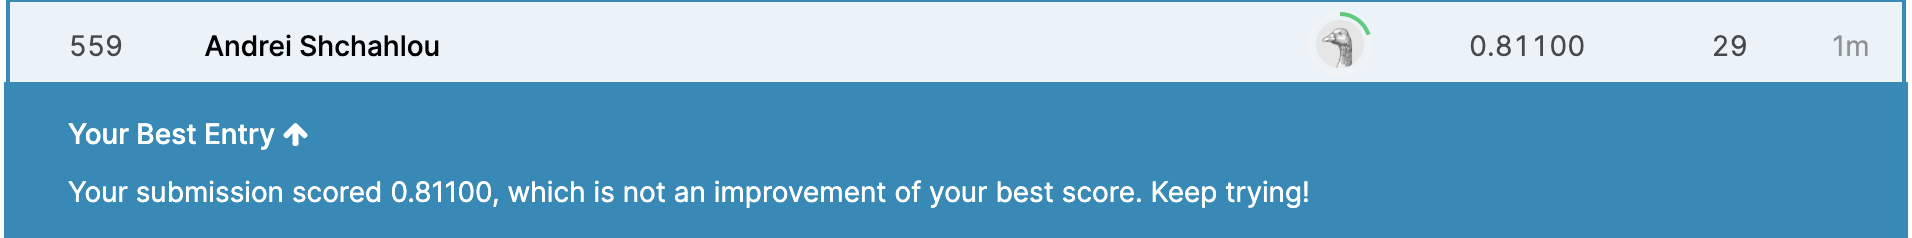

In [3]:
from IPython.display import Image
Image("score.png")